In [ ]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2022.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

## Prerequisites

### Load Qiskit and Required Libraries

In [1]:
run_experiment = False
dynamical_decoupling = False

from qiskit import IBMQ, transpile, schedule, pulse
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import XGate, YGate, RZGate, CXGate
from qiskit.pulse import DriveChannel
import qiskit.quantum_info as qi

from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

from qiskit.opflow import (I, X, Y, Z, Zero, One, MatrixEvolution, PauliTrotterEvolution, Suzuki,
                           StateFn, Zero, One, PauliExpectation, PauliOp, SummedOp, OperatorBase)

from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import TemplateOptimization, ALAPSchedule, DynamicalDecoupling
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder, rzx_templates

from qiskit.converters import circuit_to_dag, dag_to_circuit # for bespoke transpilation
from qiskit.dagcircuit import DAGCircuit, DAGNode

from qiskit.scheduler.config import ScheduleConfig
from qiskit.visualization import plot_circuit_layout, plot_error_map, timeline_drawer

import copy
import numpy as np
import scipy.linalg as lng
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [5, 5]

### Load IBM Quantum Account
Try Nick's then John's.

In [2]:
IBMQ.load_account()
try:
    provider = IBMQ.get_provider(hub='ibm-q-internal', group='mission-critical', project='bronn')
    backend = provider.get_backend('ibm_lagos')
except:
    provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
    backend = provider.get_backend('ibmq_bogota') # checking gate directions

### Load Backend Information (for Pulse)

In [3]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map

# Build Circuits from Model Hamiltonian

## Define the System Hamiltonian

John wrote down the system Hamiltonian as

$$ H = \mu\sum_{i=0}^N c^{\dagger}_i c_i + t \sum_{i=0}^{N-1} (c^{\dagger}_ic_{i+1} + c^{\dagger}_{i+1}c_i) + \Delta \sum_{i=0}^{N-1}(c^{\dagger}_i c^{\dagger}_{i+1} + c_{i+1}c_i) + U \sum_{i=0}^{N-1} c^{\dagger}_i c_i c^{\dagger}_{i+1} c_{i+1} $$

where we can use the new `FermionicOp` class to write this general Hamiltonian for 2 site.

In terms of Majorana operators $\gamma^x_i = c^{\dagger}_i + c_i$ and $\gamma^x_i = i(c^{\dagger}_i - c_i)$ we have

$$ H = -\frac{2\mu + U}{4} \sum_{i=0}^N\gamma^x_i\gamma^y_i + \frac{t+\Delta}{2}\sum_{i=0}^{N-1} \gamma^x_i\gamma^y_{i+1} + \frac{t-\Delta}{2} \sum_{i=0}^{N-1} \gamma^y_i\gamma^x_{i+1} + \frac{U}{4}  \sum_{i=0}^{N-1}\gamma^x_i\gamma^y_i\gamma^x_{i+1}\gamma^y_{i+1}$$

In [4]:
#hm = sum(FermionicOp(label) for label in ['IIN', 'INI', 'NII'])
#ht = FermionicOp('I+-') - FermionicOp('I-+') + FermionicOp('+-I') - FermionicOp('-+I')
#hD = FermionicOp('I++') - FermionicOp('I--') + FermionicOp('++I') - FermionicOp('--I')
#hU = sum(FermionicOp(label) for label in ['INN', 'NNI'])

# better to use sparse labels to not get sign confusion
hm = sum(FermionicOp(label) for label in ['N_0', 'N_1', 'N_2'])
ht = sum(FermionicOp(label) for label in ['+_0 -_1', '+_1 -_2', 
                                          '+_1 -_0', '+_2 -_1'])
hD = sum(FermionicOp(label) for label in ['+_0 +_1', '+_1 +_2', 
                                          '-_1 -_0', '-_2 -_1'])
hU = sum(FermionicOp(label) for label in ['N_0 N_1', 'N_1 N_2'])

### Transform Fermionic to Pauli Hamiltonian
Bravyi-Kitaev and BKSuperFast are also built into Qiskit.

In [5]:
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper) # should not give 2-qubit reduction error

# parameters defined here due to incompatibility with Qiskit Nature
mu = Parameter('μ')
TT = Parameter('T')
DD = Parameter('Δ')
UU = Parameter('U')

hm_pauli = mu*(converter.convert(hm))
ht_pauli = TT*(converter.convert(ht))
hD_pauli = DD*(converter.convert(hD))
hU_pauli = UU*(converter.convert(hU))

ham_pauli = hm_pauli + ht_pauli + hD_pauli + hU_pauli
print(ham_pauli)

SummedOp([
  1.0*μ * (
    1.5 * III
    - 0.5 * ZII
    - 0.5 * IZI
    - 0.5 * IIZ
  ),
  1.0*T * (
    0.5 * XXI
    + 0.5 * YYI
    + 0.5 * IXX
    + 0.5 * IYY
  ),
  1.0*Δ * (
    0.5 * XXI
    - 0.5 * YYI
    + 0.5 * IXX
    - 0.5 * IYY
  ),
  1.0*U * (
    0.5 * III
    - 0.25 * ZII
    - 0.5 * IZI
    + 0.25 * ZZI
    - 0.25 * IIZ
    + 0.25 * IZZ
  )
])


## Build Resonance Hamiltonian

Converting John's notation to little-endian:
$$H = -\frac{1}{2}\omega IIZ + H_{\rm Pauli}\otimes I + c IXX$$
Parsing in `opflow` is very dependent on how you build Hamiltonian.

In [6]:
cc = Parameter('c')
ww = Parameter('ω')

def build_resonance_ham(h0: OperatorBase) -> SummedOp:
    nq = h0.num_qubits
    h_jw = []
    for op in h0:
        for pop in op:
            h_jw.append((pop^I).to_pauli_op())
    oplist = [-0.5*ww*((I^(nq))^Z), cc*((I^(nq-1))^X^X)]
    oplist += h_jw
    return SummedOp(oplist)

## Time Evolve Resonance Hamiltonian

In [7]:
tt = Parameter('t')
res_ham = build_resonance_ham(ham_pauli)
U_ham = (tt*res_ham).exp_i()
#print(U_ham)

/Users/nick/Documents/ibmQ/qiskit-terra/qiskit/opflow/primitive_ops/pauli_sum_op.py:359: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  Pauli((self.primitive.table.Z[0], self.primitive.table.X[0])),


## Trotterize Unitary Evolution Operator
Why do random subcircuit appear sometimes? One hypothesis: parsing each coefficient with `Parameter`s expanded vs being multiplied by a grouping of `PauliOp`s might be it (observed this behavior at Heidelberg workshop).

/Users/nick/anaconda3/envs/qiskit-dev/lib/python3.9/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


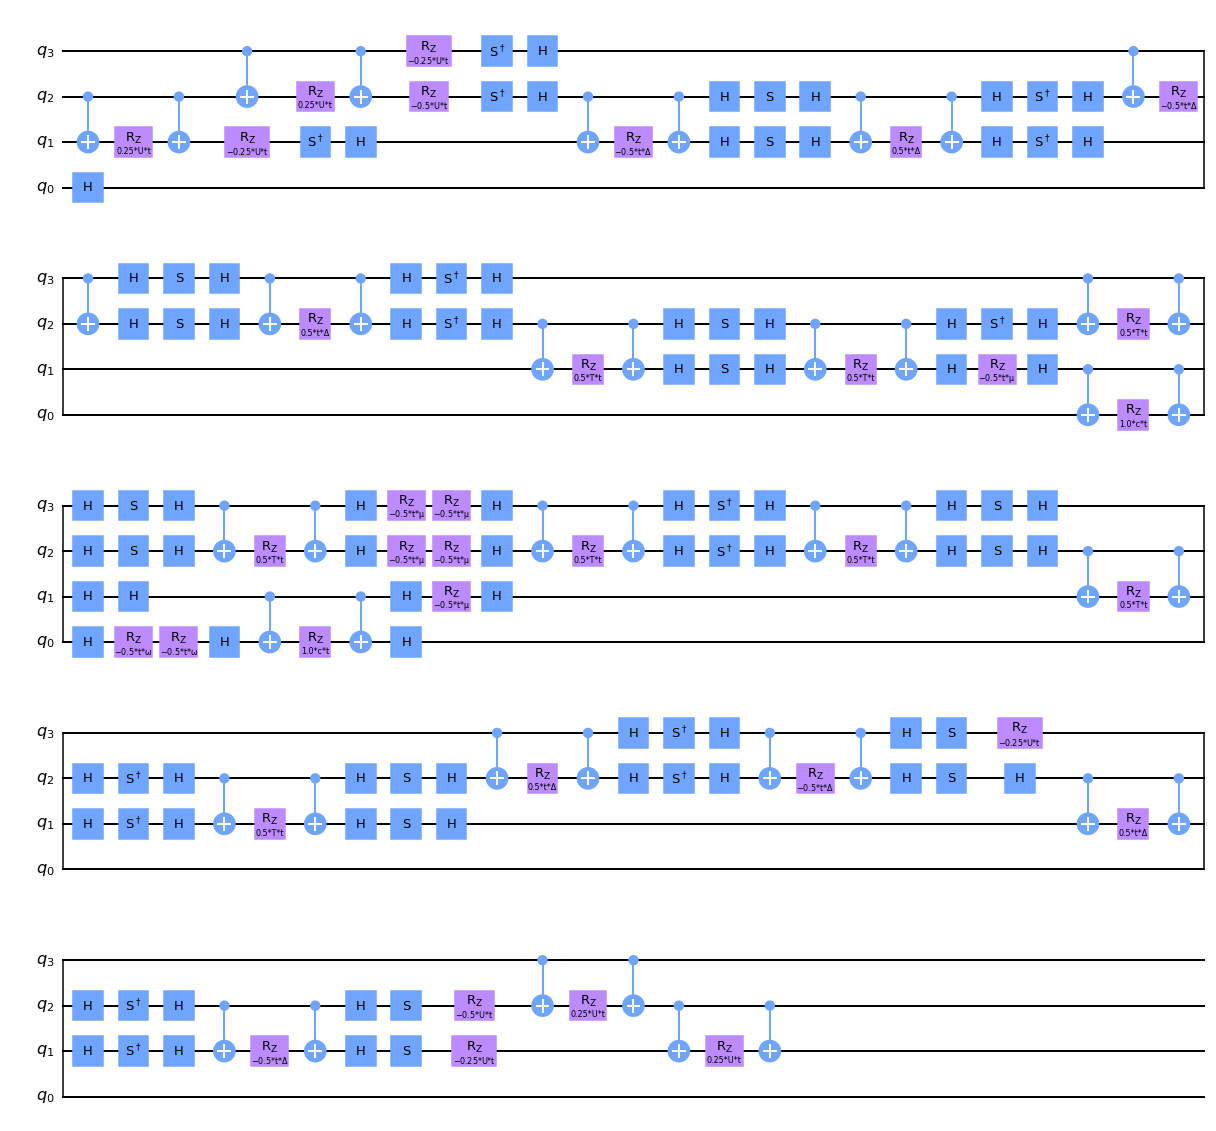

In [8]:
trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(U_ham)
trot_circ = trot_op.to_circuit()
trot_circ.draw(output='mpl', reverse_bits=True)

# Transpile Circuits to Quantum Backend

## *Incredibly* useful notes on what we're doing

Transpilation will take place "by hand" so that we can introduce the template optimization at the correct point. Each *pass* of the transpiler is classified as either an analysis or transformation pass. Template optimization consists of two passes:
- `TemplateOptimization` is an analysis pass that adds the templates (similar to circuit equivalences), in this case specified by `rzx_templates()` 
- `RZXCalibrationBuilder` is a transformation pass that replaces $ZX(\theta)$ gates with the locally-equivalent scaled Pulse gates

The **order** of transpilation and where the backend information such as layout and native gate set are incredibly important and the following heuristics were able to get this to work:

- The circuit must be transpiled to an `initial_layout` since the controlled-`RZGate` operations go across unconnected qubit pairs. At this point it seems best to leave the `basis_gate` set the same as that used in Trotterization.

- Next the `TemplateOptimization` can be run (since the simplication will respect qubit layout), running on Nick's dev fork branch `template-param-expression` (Qiskit Terra [PR 6899](https://github.com/Qiskit/qiskit-terra/pull/6899)) will allow `Parameter`s to be passed through this step.

- The `TemplateOptimization` will miss some patterns because the template parameters will conflict with finding a maximal match (Qiskit Terra [Issue 6974](https://github.com/Qiskit/qiskit-terra/issues/6974)). Here we run **Bespoke Passes** that combine consecutive gates with `Parameter`s (`RZGate`s in this case) and force $ZZ$-like patterns to match and be replated with the inverse from the template.

- Heavily transpile (`optimization_level=3`) the circuit without reference to basis gates (this was necessary for some reason?)

- Final bespoke combination of `RZGate`s.

- There are still a couple patterns of CNOT-singles-CNOT that could be optimized, can add templates for those (TODO).

## Backend Information

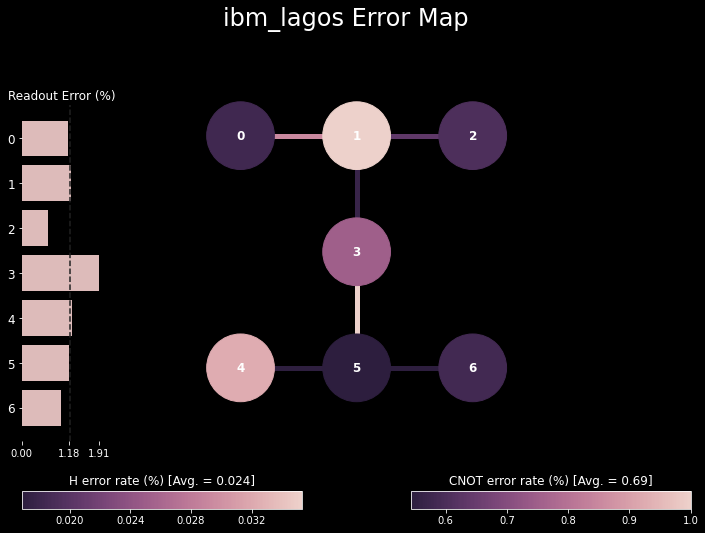

In [9]:
plot_error_map(backend)

In [10]:
qr = QuantumRegister(backend_config.num_qubits, 'q')
cr = ClassicalRegister(backend_config.num_qubits, 'c')
initial_layout = [2, 1, 3, 5] 
native_gates = ['rz', 'sx', 'rzx', 'x']

In [11]:
avg_gate_error = 0
for ii in range(len(initial_layout)-1):
    q0 = initial_layout[ii]
    q1 = initial_layout[ii+1]
    avg_gate_error += backend.properties().gate_property('cx')[(q0, q1)]['gate_error'][0]

avg_gate_error /= len(initial_layout)-1
print('Avg 2-qubit gate error is '+str(avg_gate_error))

Avg 2-qubit gate error is 0.007327944720005909


## Template Optimization and Basic Transpilation

/Users/nick/anaconda3/envs/qiskit-dev/lib/python3.9/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


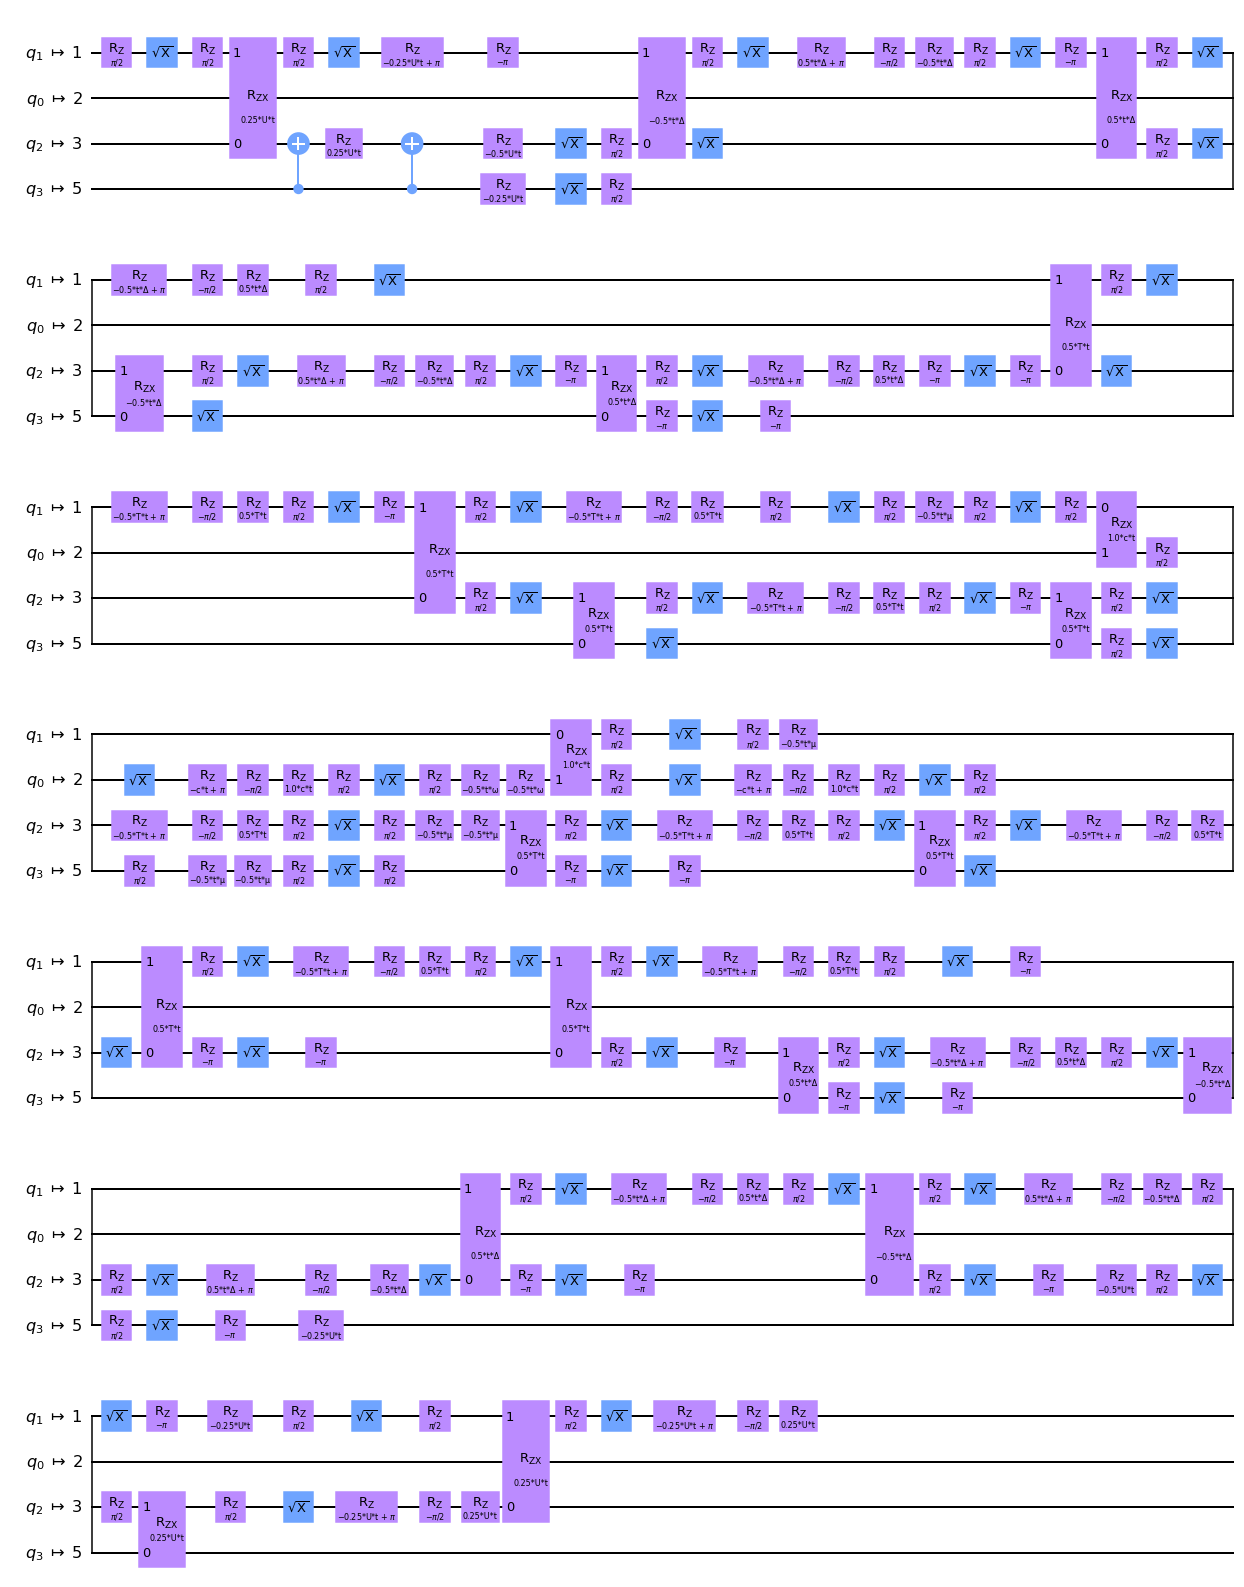

In [12]:
trot_circ1 = transpile(trot_circ, optimization_level=0)
pass_ = TemplateOptimization(**rzx_templates.rzx_templates()) 
trot_circ2 = PassManager(pass_).run(trot_circ1)
trot_circ3 = transpile(trot_circ2, basis_gates=native_gates + ['cx'],
                      backend=backend, initial_layout=initial_layout)
trot_circ3.draw(output='mpl', idle_wires=False)

## Bespoke Transpilation Time

So far, just doing one to combine consecutive gates. Does not look like modulo $2\pi$ is necessary here.

### "Forced" CNOT-RZ-CNOT Optmization Workaround

In [13]:
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode
from copy import deepcopy

def get_zz_temp_sub() -> QuantumCircuit:
    rzx_dag = circuit_to_dag(deepcopy(rzx_templates.rzx_templates(['zz3'])['template_list'][0]))
    temp_cx1_node = rzx_dag.front_layer()[0]
    for gp in rzx_dag.bfs_successors(temp_cx1_node):
        if gp[0] == temp_cx1_node:
            if isinstance(gp[1][0].op, CXGate) and isinstance(gp[1][1].op, RZGate):
                temp_rz_node = gp[1][1]
                temp_cx2_node = gp[1][0]

                rzx_dag.remove_op_node(temp_cx1_node)
                rzx_dag.remove_op_node(temp_rz_node)
                rzx_dag.remove_op_node(temp_cx2_node)
    
    return dag_to_circuit(rzx_dag).inverse()

def sub_zz_in_dag(dag: DAGCircuit, cx1_node: DAGNode, rz_node: DAGNode, cx2_node: DAGNode) -> DAGCircuit:
    zz_temp_sub = get_zz_temp_sub().assign_parameters({get_zz_temp_sub().parameters[0]: rz_node.op.params[0]})
    dag.remove_op_node(rz_node)
    dag.remove_op_node(cx2_node)
    
    qr = QuantumRegister(2, 'q')
    mini_dag = DAGCircuit()
    mini_dag.add_qreg(qr)
    for idx, (instr, qargs, cargs) in enumerate(zz_temp_sub.data):
        mini_dag.apply_operation_back(instr, qargs=qargs)

    dag.substitute_node_with_dag(node=cx1_node, input_dag=mini_dag, wires=[qr[0], qr[1]])
    return dag

def forced_zz_temp_sub(dag: DAGCircuit) -> DAGCircuit:
    cx_runs = dag.collect_runs('cx')
    for run in cx_runs:
        cx1_node = run[0]
        gp = next(dag.bfs_successors(cx1_node))
        if isinstance(gp[0].op, CXGate): # dunno why this is needed
            if isinstance(gp[1][0], DAGOpNode) and isinstance(gp[1][1], DAGOpNode):
                if isinstance(gp[1][0].op, CXGate) and isinstance(gp[1][1].op, RZGate):
                    rz_node = gp[1][1]
                    cx2_node = gp[1][0]
                    gp1 = next(dag.bfs_successors(rz_node))
                    if cx2_node in gp1[1]:
                        if ((cx1_node.qargs[0].index == cx2_node.qargs[0].index) and
                            (cx1_node.qargs[1].index == cx2_node.qargs[1].index) and
                            (cx2_node.qargs[1].index == rz_node.qargs[0].index)):

                            dag = sub_zz_in_dag(dag, cx1_node, rz_node, cx2_node)

    return dag

### Combine Consectutive Gates Pass

In [14]:
def combine_runs(dag: DAGNode, gate_str: str) -> DAGCircuit:
    runs = dag.collect_runs([gate_str])
    for run in runs:
        partition = []
        chunk = []
        for ii in range(len(run)-1):
            chunk.append(run[ii])

            qargs0 = run[ii].qargs
            qargs1 = run[ii+1].qargs

            if qargs0 != qargs1:
                partition.append(chunk)
                chunk = []

        chunk.append(run[-1])
        partition.append(chunk)

        # simplify each chunk in the partition
        for chunk in partition:
            theta = 0
            for ii in range(len(chunk)):
                theta += chunk[ii].op.params[0]

            # set the first chunk to sum of params
            chunk[0].op.params[0] = theta

            # remove remaining chunks if any
            if len(chunk) > 1:
                for nn in chunk[1:]:
                    dag.remove_op_node(nn)
    return dag

### Run Bespoke Passes

<ipython-input-13-885a07d9f29e>:45: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  if ((cx1_node.qargs[0].index == cx2_node.qargs[0].index) and
<ipython-input-13-885a07d9f29e>:46: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  (cx1_node.qargs[1].index == cx2_node.qargs[1].index) and
<ipython-input-13-885a07d9f29e>:47: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  (cx2_node.qargs[1].index == rz_node.qargs[0].index)):


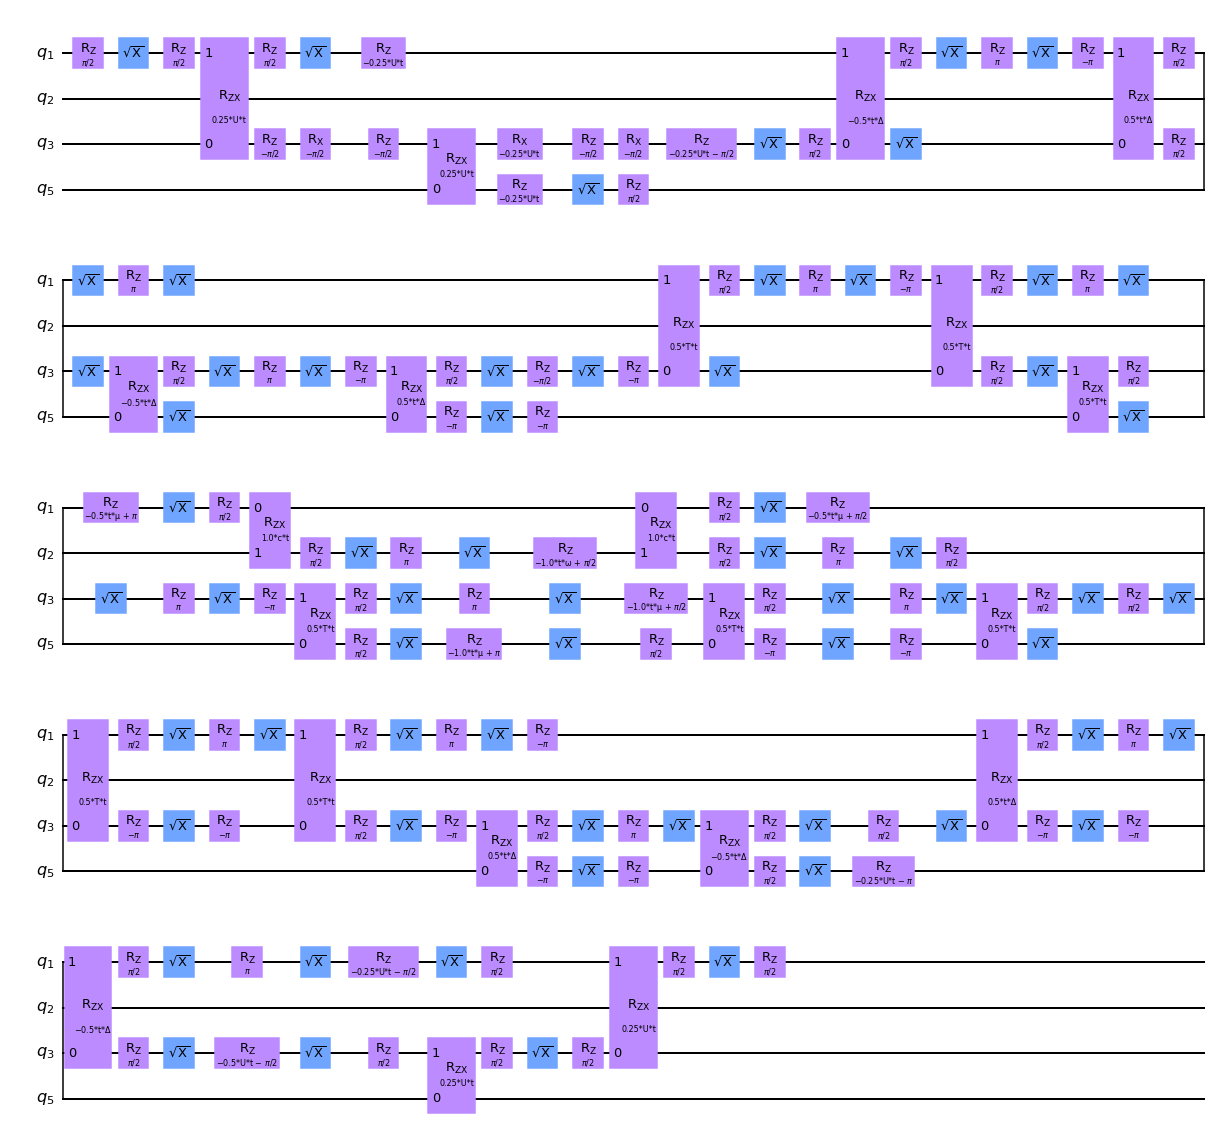

In [15]:
dag = circuit_to_dag(trot_circ3)
dag = forced_zz_temp_sub(dag)
dag = combine_runs(dag, 'rz')
dag = combine_runs(dag, 'rzx')
trot_circ4 = dag_to_circuit(dag)
trot_circ4.draw(output='mpl', idle_wires=False)

## Game Plan
The above circuit is as transpiled as possible without binding parameters and adding the calibrations for the `RZXGate`s. This will form the unit of the sweeps we run.

# Build Sweep Experiment

In [16]:
trot_unit = trot_circ4

exp_str = 'm_sweep' # or 't_sweep' or 'c_sweep' or 'y_sweep'

## Set Model Hamiltonian Parameters

In [17]:
ham_pauli

SummedOp([PauliSumOp(SparsePauliOp(['III', 'ZII', 'IZI', 'IIZ'],
              coeffs=[ 1.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j]), coeff=1.0*μ), PauliSumOp(SparsePauliOp(['XXI', 'YYI', 'IXX', 'IYY'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j]), coeff=1.0*T), PauliSumOp(SparsePauliOp(['XXI', 'YYI', 'IXX', 'IYY'],
              coeffs=[ 0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j]), coeff=1.0*Δ), PauliSumOp(SparsePauliOp(['III', 'ZII', 'IZI', 'ZZI', 'IIZ', 'IZZ'],
              coeffs=[ 0.5 +0.j, -0.25+0.j, -0.5 +0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j]), coeff=1.0*U)], coeff=1.0, abelian=False)

Grouping by terms, the Model Hamiltonian is written as (PLEASE CHECK JOHN!!!)
$$
H_{\rm Pauli} = -\frac{2\mu + U}{4} (IIZ + IZI + ZII) + \frac{t+\Delta}{2} (IXX + XXI) + \frac{t-\Delta}{2} (IYY + YYI) + \frac{U}{4} (IZZ + ZZI - IZI) \\
\equiv m(IIZ + IZI + ZII) + x (IXX + XXI) + y (IYY + YYI) + z (IZZ + ZZI - IZI)
$$
negelecting the identity term. 

In [18]:
x_set = 1.5
#z_set = 0.0 # runs (z off!)
z_set = 0.4 # runs (z on!)

### Invert Parameters before Binding

$$
t = x + y \qquad \Delta = x - y \qquad U = 4z \qquad \mu = -2(m+z)
$$

(This now happens differently in each param sweep step)

In [19]:
# job will choke on Parameter keys, convert to strings

def stringify(param_bind: dict) -> dict:
    param_bind_str = {}
    for key in param_bind.keys():
        param_bind_str[str(key)] = param_bind[key]
    
    return param_bind_str      

## Timing Sweep Experiment

### Set Remaining Parameters

In [20]:
if exp_str == 't_sweep':
    # runs 1-3
    #c_set = 0.4
    #m_set = 1.0
    #y_set = 0.4
    
    # runs 115-
    c_set = 0.3
    m_set = 0.1
    y_set = 0.1
    
    T_set = x_set + y_set
    D_set = x_set - y_set
    U_set = 4*z_set
    mu_set = -2*(m_set + z_set)
    
    param_bind = {TT: T_set, DD: D_set, UU: U_set, mu: mu_set, cc: c_set}

### Set Experimental Parameters

In [21]:
if exp_str == 't_sweep':
    # Create the range of t values
    #t0 = 1.0 # run 1
    #t0 = 4.0 # run 2
    #t0 = 3.0 # run 3
    #dt = 1.0
    #Nt = 3 # ntb - max num of circuits is 900 - runs 1, 2, 3
    #t_range = [ti*dt + t0 for ti in range(Nt)] 
    
    t_range = [1.0, 3.0, 5.0, 10.0] # runs 115

    # Create the range of dt values
    dt_range = [0.1, 0.2, 0.5, 1.0] # runs 1, 2, 115
    #dt_range = [0.8, 1.2, 1.5, 2.0] # run 3

    # Create the range of w values
    # w0 = -3.7 # runs 1-4
    # w0 = -3.5
    # dw = 0.1
    # Nw = 75 # ntb - now 3*4*75 = 900, so we're good!
    # w_range = [wi*dw + w0 for wi in range(Nw)] 
    
    # runs 115
    dw = 0.14
    w_range = np.linspace(-3.5, 3.5, 51)

### Bind Parameters and Append Circuits

In [22]:
if exp_str == 't_sweep':
    #Bind the parameters 
    circ_w = []
    param_decoder = []
    for t_set in t_range:
        for dt_set in dt_range:
            # Now let's add the circuits together
            NT = int(t_set/dt_set)
            print(NT*dt_set,', ',t_set, ', ', dt_set)
            trot_circ_total = copy.deepcopy(trot_unit)
            for ti in range (1,NT):
                trot_circ_total.append(trot_unit, qr)
            param_bind[tt] = dt_set # KEEP THIS LINE
            for w_set in w_range:
                circ_str = 'Freq sweep w='+str(round(w_set, 2))+', '+str(round(NT, 3))+' Trotter steps (2nd order)'
                bound_circ = trot_circ_total.bind_parameters({**param_bind, ww: w_set})
                temp_circ = QuantumCircuit(qr, cr, name=circ_str, 
                                           metadata=stringify({**param_bind, ww: w_set}))
                temp_circ.append(bound_circ, qr)
                temp_circ.measure(qr[initial_layout[0]], cr[initial_layout[0]])
                circ_w.append(temp_circ)
                param_decoder.append(['t=' + str(t_set) + ', dt=' + str(dt_set) + ', w=' + str(round(w_set,2))])

## $c$ Sweep Experiment

### Set Remaining Parameters

In [23]:
if exp_str == 'c_sweep':
    # t_set = 5.0 # job 4
    # dt_set = 1.2 # job 4
    # m_set = 1.0 # job 4
    # y_set = 0.4 # job 4
    
    t_set = 5.0 # jobs 101-103
    # dt_set = 0.7 # jobs 101-103
    dt_set = 0.1 # jobs 122-
    
    # m_set = 0.0 # job 101
    # y_set = 0.0 # job 101
    
    m_set = 0.1 # jobs 102, 103, 123-
    y_set = 0.1 # jobs 102, 103, 123-
    
    T_set = x_set + y_set
    D_set = x_set - y_set
    U_set = 4*z_set
    mu_set = -2*(m_set + z_set)

    param_bind = {TT: T_set, DD: D_set, UU: U_set, mu: mu_set, tt: dt_set}

### Set Experimental Parameters

In [24]:
if exp_str == 'c_sweep':
    
    # Create the range of c values
    #c0 = 0.1
    c0 = 0.03 # run 101
    #dc = 0.1
    dc = 0.03 # run 101
    Nc = 12
    #c_range = [ci*dc + c0 for ci in range(Nc)]
    
    c_range = np.linspace(0.03, 0.06, 2) # run 123
    
    # rest of these failed
    # c_range = np.linspace(0.09, 0.12, 2) # run 123
    # c_range = np.linspace(0.15, 0.18, 2) # run 124
    # c_range = np.linspace(0.21, 0.24, 2) # run 125
    # c_range = np.linspace(0.27, 0.30, 2) # run 126
    # c_range = np.linspace(0.33, 0.36, 2) # run 127

    # Create the range of w values
    w0 = -3.7
    dw = 0.1
    Nw = 75 
    w_range = [wi*dw + w0 for wi in range(Nw)]

In [25]:
if exp_str == 'c_sweep':
    # Now let's add the circuits together
    NT = int(t_set/dt_set)
    trot_circ_total = copy.deepcopy(trot_unit)
    for ti in range (1,NT):
        trot_circ_total.append(trot_unit, qr)

    #Bind the parameters 
    circ_w = []
    param_decoder = []
    for c_set in c_range:
        param_bind[cc] = c_set
        for w_set in w_range:
            circ_str = 'Freq sweep w='+str(round(w_set, 2))+', $c$ = '+str(round(c_set, 2))
            bound_circ = trot_circ_total.bind_parameters({**param_bind, ww: w_set})
            temp_circ = QuantumCircuit(qr, cr, name=circ_str, 
                                       metadata=stringify({**param_bind, ww: w_set}))
            temp_circ.append(bound_circ, qr)
            temp_circ.measure(qr[initial_layout[0]], cr[initial_layout[0]])
            circ_w.append(temp_circ)
            param_decoder.append(['c=' + str(round(c_set, 2)) + ', w=' + str(round(w_set, 2))])

## $m$ Sweep Experiment

### Set Remaining Parameters

In [26]:
if exp_str == 'm_sweep':
    t_set = 5.0
    dt_set = 0.7 
    c_set = 0.3
    
    # y_set = -1.5 # runs 1
    # y_set = -1.3 # runs 2
    # y_set = -1.1 # runs 3
    # y_set = -0.9 # runs 4
    # y_set = -0.7 # runs 5
    # y_set = -0.5 # runs 6
    # y_set = -0.3 # runs 7
    # y_set = -0.1 # runs 8
    # y_set = 0.1 # runs 9
    # y_set = 0.3 # runs 10
    # y_set = 0.5 # runs 11
    # y_set = 0.7 # runs 12
    # y_set = 0.9 # runs 13
    # y_set = 1.1 # runs 14
    # y_set = 1.3 # runs 15
    y_set = 1.5 # runs 16

    U_set = 4*z_set

    param_bind = {UU: U_set, tt: dt_set, cc: c_set}
    m_range = np.linspace(-1.5, 1.5, 16) 
    w_range = np.linspace(-3.5, 3.5, 51)

In [27]:
if exp_str == 'm_sweep':
    # Now let's add the circuits together
    NT = int(t_set/dt_set)
    trot_circ_total = copy.deepcopy(trot_unit)
    for ti in range (1, NT):
        trot_circ_total.append(trot_unit, qr)

    #Bind the parameters 
    circ_w = []
    param_decoder = []
    for m_set in m_range:
        mu_set = -2*(m_set + z_set)
        T_set = x_set + y_set
        D_set = x_set - y_set
        
        param_bind[mu] = mu_set
        param_bind[TT] = T_set
        param_bind[DD] = D_set
        for w_set in w_range:
            circ_str = 'Freq sweep w='+str(round(w_set, 2))+', $\mu$ = '+str(round(mu_set, 2))
            bound_circ = trot_circ_total.bind_parameters({**param_bind, ww: w_set})
            temp_circ = QuantumCircuit(qr, cr, name=circ_str, 
                                       metadata=stringify({**param_bind, ww: w_set}))
            temp_circ.append(bound_circ, qr)
            temp_circ.measure(qr[initial_layout[0]], cr[initial_layout[0]])
            circ_w.append(temp_circ)
            param_decoder.append(['y='+str(round(y_set, 2))+', m=' + str(round(m_set, 2)) + 
                                  ', w=' + str(round(w_set, 2))])

## $y$ Sweep Experiment

### Set Remaining Parameters

In [28]:
if exp_str == 'y_sweep':
    t_set = 5.0
    dt_set = 0.7 # runs
    c_set = 0.3
    m_set = 0.0 # runs 
    
    # z_set = -0.5 # runs
    # z_set = -0.4 # runs
    # z_set = -0.3 # runs 
    # z_set = -0.2 # runs 
    # z_set = -0.1 # runs 
    z_set = 0.0 # runs 
    # z_set = 0.1 # runs 
    # z_set = 0.2 # runs 
    # z_set = 0.3 # runs 
    # z_set = 0.4 # runs 
    #.z_set = 0.5 # runs 
    
    mu_set = -2*(m_set + z_set)
    U_set = 4*z_set
    
    param_bind = {mu: mu_set, UU: U_set, tt: dt_set, cc: c_set}
    
    #y_range = np.linspace(-1.5, 1.5, 16) # runs 104-114
    
    #y_range = np.linspace(-1.5, -0.9, 4) # run 116 - nevermind too long!
    #y_range = np.linspace(-1.5, -1.3, 2) # run 116 (4 scans?), 122
    #y_range = np.linspace(-1.1, -0.7, 3) # run 117
    #y_range = np.linspace(-0.5, -0.1, 3) # run 118
    #y_range = np.linspace(0.1, 0.5, 3) # run 119
    #y_range = np.linspace(0.7, 1.1, 3) # run 120
    #y_range = np.linspace(1.3, 1.5, 2) # run 121
    
    #y_range = [-1.5] # run 128 (fail)
    #y_range = np.linspace(-1.5, -0.7, 5) # run 128
    #y_range = np.linspace(-0.5, 0.3, 5) # run 129 (fail), 129
    y_range = np.linspace(0.5, 1.3, 5) # run 130 (fail), 130
    #y_range = np.linspace(1.5, 1.5, 1) # run 131
    
    w_range = np.linspace(-3.5, 3.5, 51)

In [29]:
if exp_str == 'y_sweep':
    # Now let's add the circuits together
    NT = int(t_set/dt_set)
    trot_circ_total = copy.deepcopy(trot_unit)
    for ti in range (1, NT):
        trot_circ_total.append(trot_unit, qr)

    #Bind the parameters 
    circ_w = []
    param_decoder = []
    for y_set in y_range:
        T_set = x_set + y_set
        D_set = x_set - y_set
        
        param_bind[TT] = T_set
        param_bind[DD] = D_set
        for w_set in w_range:
            circ_str = 'Freq sweep w='+str(round(w_set, 2))+', $z$ = '+str(round(z_set, 2))
            bound_circ = trot_circ_total.bind_parameters({**param_bind, ww: w_set})
            temp_circ = QuantumCircuit(qr, cr, name=circ_str, 
                                       metadata=stringify({**param_bind, ww: w_set}))
            temp_circ.append(bound_circ, qr)
            temp_circ.measure(qr[initial_layout[0]], cr[initial_layout[0]])
            circ_w.append(temp_circ)
            param_decoder.append(['y='+str(round(y_set, 2))+', z=' + str(round(z_set, 2)) + 
                                  ', w=' + str(round(w_set, 2))])

## Final Transpilation Steps

This takes impossibly long for 4 qubits.

In [30]:
res_circ_scaled_trans = transpile(circ_w, backend, basis_gates=native_gates)
res_circ_digital_trans = transpile(circ_w, backend)

In [31]:
pass_ = RZXCalibrationBuilder(backend)
res_circ_scaled_trans1 = PassManager(pass_).run(res_circ_scaled_trans)

## Dynamical Decoupling

Following [this tutorial](https://qiskit.org/documentation/stubs/qiskit.transpiler.passes.DynamicalDecoupling.html), we can automatically add dynamical decoupling sequences. Currently this seems a bit limited to "native" Qiskit gates, and the duration information must be pulled from the `inst_sched_map`.

In [32]:
if dynamical_decoupling:
    inst_durs = []

    # single qubit gates
    for qubit in range(backend_config.num_qubits):
        for inst_str in inst_sched_map.qubit_instructions(qubits=[qubit]):
            inst = inst_sched_map.get(inst_str, qubits=[qubit])
            inst_durs.append((inst_str, qubit, inst.duration))
            if inst_str == 'x':
                inst_durs.append(('y', qubit, inst.duration))

    # two qubit gates
    for qc in range(backend_config.num_qubits):
        for qt in range(backend_config.num_qubits):
            for inst_str in inst_sched_map.qubit_instructions(qubits=[qc, qt]):
                inst = inst_sched_map.get(inst_str, qubits=[qc, qt])
                inst_durs.append((inst_str, [qc, qt], inst.duration))
                inst_durs.append(('rzx', [qc, qt], inst.duration)) # TOTALLY FAKING IT

    durations = InstructionDurations(inst_durs)

In [33]:
#res_circ_nodd = transpile(res_circ_scaled_trans1, backend, scheduling_method='alap')

In [34]:
if dynamical_decoupling:
    # balanced X-X sequence on all qubits
    dd_x2_sequence = [XGate(), XGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, dd_x2_sequence)])
    res_circ_ddx2 = pm.run(res_circ_scaled_trans1)

In [35]:
if dynamical_decoupling:
    dd_xy4_sequence = [XGate(), YGate(), XGate(), YGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, dd_xy4_sequence)])
    res_circ_ddxy4 = pm.run(res_circ_scaled_trans1)

In [36]:
if dynamical_decoupling:
    # for some reason dd sequence does not seem to be inserted until after entangling gate (end looks fine)
    start_time = 0 #880000
    time_window = 30000
    time_range=[start_time, start_time+time_window]
    timeline_drawer(res_circ_ddxy4[-1], time_range=time_range)

### Add Calibrations for Missing Gates

The`YGate` is not a basis gate of our backend (unlike 'x'). We can build a pulse schedule from 'x' and add it to the circuits.

In [37]:
if dynamical_decoupling:
    for qubit in range(backend_config.num_qubits):
        with pulse.build('y gate for qubit '+str(qubit)) as sched:
            with pulse.phase_offset(np.pi/2, DriveChannel(qubit)):
                x_gate = inst_sched_map.get('x', qubits=[qubit])
                pulse.call(x_gate)

            for circ in res_circ_ddxy4:
                circ.add_calibration('y', [qubit], sched)


In [38]:
# okay this does not work for some reason, but confirmed it on a simpler circuit
#schedule(res_circ_ddxy4[-1], backend).draw(time_range=time_range)

## Compare digital and scaled circuits

In [39]:
circ_num = -1
scaled_sched = schedule(res_circ_scaled_trans1[circ_num], backend)
basis_sched = schedule(res_circ_digital_trans[circ_num], backend)

### Count Operations

In [40]:
res_circ_scaled_trans1[circ_num].count_ops()

OrderedDict([('rz', 396), ('sx', 212), ('rzx', 154), ('measure', 1)])

In [41]:
res_circ_digital_trans[circ_num].count_ops()

OrderedDict([('rz', 355), ('sx', 184), ('cx', 184), ('measure', 1)])

In [42]:
dag = circuit_to_dag(res_circ_scaled_trans1[circ_num])
rzx_runs = dag.collect_runs(['rzx'])

est_fid_rzx = 1
for rzx_run in rzx_runs:
    angle = rzx_run[0].op.params[0]
    this_rzx_error = (abs(float(angle))/(np.pi/2))*avg_gate_error
    est_fid_rzx *= (1-this_rzx_error)
    
print('Scaled Circuit estimated fidelity is %2.f%%' % (est_fid_rzx*100))

Scaled Circuit estimated fidelity is 73%


In [43]:
num_cx = res_circ_digital_trans[circ_num].count_ops()['cx']
est_fid_dig = (1-avg_gate_error)**num_cx
print('Digital Circuit estimated fidelity is %2.f%%' % (est_fid_dig*100))

Digital Circuit estimated fidelity is 26%


### Look at Resulting Schedules

In [44]:
print('Scaled schedule takes '+str(scaled_sched.duration)+'dt')
print('Digital schedule takes '+str(basis_sched.duration)+'dt')

Scaled schedule takes 109184dt
Digital schedule takes 220864dt


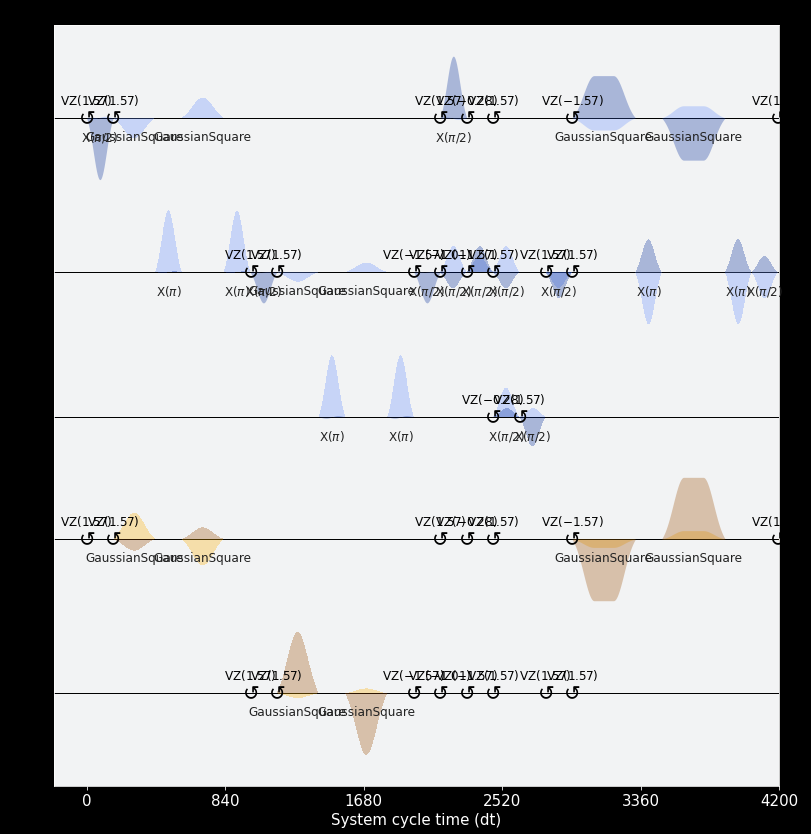

In [45]:
time_range=[0,4000]
scaled_sched.draw(time_range=time_range)

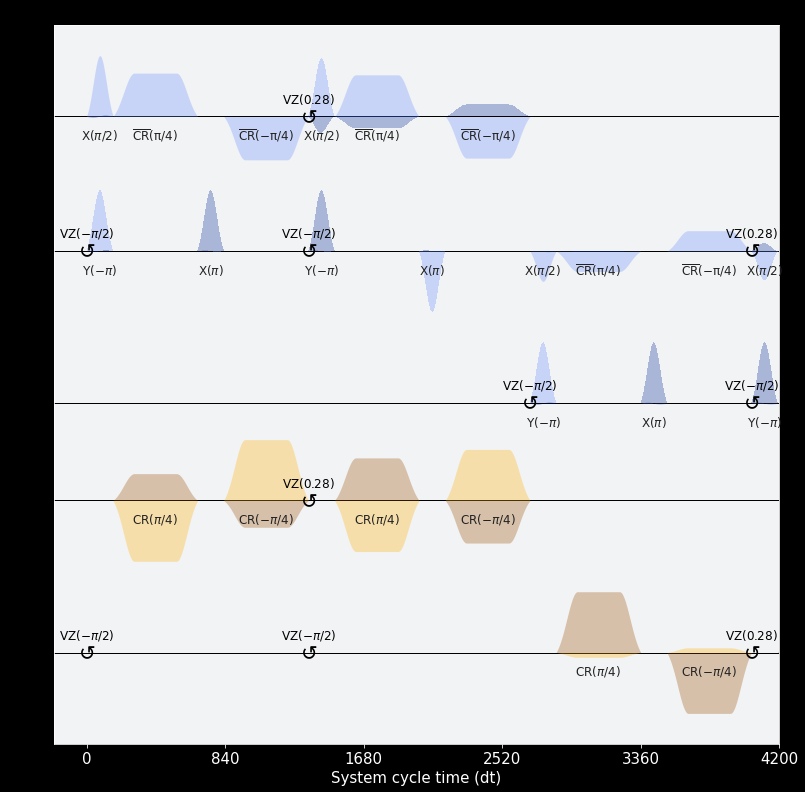

In [46]:
basis_sched.draw(time_range=time_range)

Question: How is the duration being calculated when the parameters for trans_circ_dig have not been set? 

NTB: I don't know, just noticed this as well in another notebook. My initial guess is that 1q-gates have 2 microwave pulses and the RZX are calculated to have 2 CNOTs, but this needs to be confirmed.

# Run on Quantum Hardware

In [47]:
from qiskit.tools.monitor import job_monitor

if run_that_shit:
    # run the job on a real backend
    if dynamical_decoupling:
        job = backend.run(res_circ_scaled_trans1 + res_circ_ddx2 + res_circ_ddxy4, 
                          job_name="SE_Eigensolver", meas_level=2, shots=8192)
    else:
        job = backend.run(res_circ_scaled_trans1, job_name="SE_Eigensolver", meas_level=2, shots=8192) 

    
    print(job.job_id())
    job_monitor(job)

## Or Retrieve from Previous Run

In [4]:
if not run_experiment:
    job_ids = [
            # z=0.4, c=0.3, dt=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 5-3-1-2
                '61de00a60a744a1c8999d2bd', # run 1 - m_sweep, y=-1.5
                '61de055d6113fa67a55a7b0b', # run 2 - m_sweep, y=-1.3
                '61de097ffde78b067edbb979', # run 3 - m_sweep, y=-1.1
                '61de104dd1eb0783ef492ff0', # run 4 - m_sweep, y=-0.9
                '61de14700a744a75ca99d309', # run 5 - m_sweep, y=-0.7
                '61de190a6113fa42a35a7b5d', # run 6 - m_sweep, y=-0.5
                '61de1d308df394ab513317b5', # run 7 - m_sweep, y=-0.3
                '61de44239307b92e986bcaba', # run 8 - m_sweep, y=-0.1
                '61de47fb33a1eeda09f16d27', # run 9 - m_sweep, y=0.1
                '61de4c0dd1eb07d33b4930d2', # run 10 - m_sweep, y=0.3
                '61de4fa39307b9d5746bcad2', # run 11 - m_sweep, y=0.5
                '61de53470a744ad34a99d3f8', # run 12 - m_sweep, y=0.7
                '61de56f18df394184933188c', # run 13 - m_sweep, y=0.9
                '61de5aed8df3943fb3331897', # run 14 - m_sweep, y=1.1
                '61de5e9233a1ee379ff16d57', # run 15 - m_sweep, y=1.3
                '61de6271d1eb0712ae493100'] # run 16 - m_sweep, y=1.5

In [6]:
run_num = 16
job = backend.retrieve_job(job_ids[run_num-1])

In [49]:
Result = job.result().get_counts()

# Analyze Results

In [305]:
if exp_str == 't_sweep':
    t_analyze = 10.0
    dt_analyze = 1.0

    tidx = int(np.where(np.round(np.asarray(t_range), 2) == t_analyze)[0])
    dtidx = int(np.where(np.round(np.asarray(dt_range), 2) == dt_analyze)[0])

    w0 = w_range[0]
    idx0 = dtidx*len(w_range) + tidx*len(w_range)*(1+len(t_range)) # starting index
    pd0 = ['t='+str(round(t_analyze, 2))+', dt='
           +str(round(dt_analyze, 2))+', w='+str(round(w0, 2))] 
    pdf = ['t='+str(round(t_analyze, 2))+', dt='
           +str(round(dt_analyze, 2))+', w='+str(round(-w0, 2))]
    
elif exp_str == 'c_sweep':
    c_analyze = 0.03
    cidx = int(np.where(np.round(np.asarray(c_range), 2) == c_analyze)[0])
    idx0 = cidx*len(w_range) # starting index
    pd0 = ['c='+str(round(c_analyze, 2))+', w='+str(round(w0, 2))]
    pdf = ['c='+str(round(c_analyze, 2))+', w='+str(round(-w0, 2))]
    
elif exp_str == 'm_sweep':
    m_analyze = 1.5
    param_bind[mu] = -2*(m_analyze + z_set)
    midx = int(np.where(np.round(np.asarray(m_range), 2) == m_analyze)[0])
    idx0 = midx*len(w_range) # starting index
    w0 = w_range[0]
    dw = round(w_range[1] - w_range[0], 2)
    pd0 = ['y='+str(round(y_set, 2))+', m='+str(round(m_analyze, 2))+', w='+str(round(w0, 2))]
    pdf = ['y='+str(round(y_set, 2))+', m='+str(round(m_analyze, 2))+', w='+str(round(-w0, 2))]
    
elif exp_str == 'y_sweep':
    y_analyze = 0.7
    param_bind[TT] = x_set + y_analyze
    param_bind[DD] = x_set - y_analyze
    yidx = int(np.where(np.round(np.asarray(y_range), 2) == y_analyze)[0])
    idx0 = yidx*len(w_range) # starting index
    w0 = w_range[0]
    dw = round(w_range[1] - w_range[0], 2)
    pd0 = ['y='+str(round(y_set, 2))+', z='+str(round(z_set, 2))+', w='+str(round(w0, 2))]
    pdf = ['y='+str(round(y_set, 2))+', z='+str(round(z_set, 2))+', w='+str(round(-w0, 2))]

## Simulation for Analysis

In [306]:
wi0 = param_decoder.index(pd0)
wif = param_decoder.index(pdf)

# energies = np.linspace(w0, -w0, int(-2*w0/dw)+1) # w0 is negative
energies = w_range

In [307]:
gnd_state = Zero^4 # |000>
obsv = I^I^I^Z
evo_and_obsv = (U_ham @ gnd_state).adjoint() @ obsv @ U_ham @ gnd_state

### Diagonalization of Pauli Hamiltonian

In [308]:
evalues, evects = lng.eig(ham_pauli.bind_parameters(param_bind).to_matrix())

# The expected transitions
D0 = [evalues[i]-evalues[0] for i in range(0,3)]
D1 = [evalues[i]-evalues[1] for i in range(0,3)]
D2 = [evalues[i]-evalues[2] for i in range(0,3)]
D3 = [evalues[i]-evalues[3] for i in range(0,3)]
print(D0, D1, D2, D3)

[0j, (5.117406628984589+0j), (8.63481325796917+0j)] [(-5.117406628984589+0j), 0j, (3.517406628984582+0j)] [(-8.63481325796917+0j), (-3.517406628984582+0j), 0j] [(-3.0747659418653086-1.2325951644078296e-31j), (2.04264068711928-1.2325951644078296e-31j), (5.560047316103862-1.2325951644078296e-31j)]


### Qiskit Statevector Evolution (of Resonance Ham)

In [309]:
res_circ_scaled_trans[wi0].remove_final_measurements()
psi = qi.Statevector.from_instruction(res_circ_scaled_trans[wi0]).data

q0 = initial_layout[0]
Nq = int(np.log2(len(psi)))
Z_label = ''
for q in range(Nq):
    if q == Nq - 1 - q0:
        Z_label = Z_label + 'Z'
    else:
        Z_label = Z_label + 'I'
Z0 = qi.Operator.from_label(Z_label).data

In [310]:
param_bind[tt] = dt_set
try:
    param_bind[cc] = c_analyze
except:
    param_bind[cc] = c_set

prob0_final = []
for wi in range(wi0,wif+1):    
    res_circ_scaled_trans[wi].remove_final_measurements()
    psi = qi.Statevector.from_instruction(res_circ_scaled_trans[wi]).data
    P0 = np.dot(np.conjugate(psi),np.dot(Z0,psi))
    prob0_final.append(P0)

### numpy Matrix Evolution

In [311]:
prob0_matrix = []
Z0 = obsv.to_matrix()
for w_set in energies:
    HM = res_ham.bind_parameters({**param_bind, ww: w_set}).to_matrix()
    psiM = gnd_state.to_matrix()
    psiM_f = np.dot(lng.expm(-1j*HM*t_set), psiM)

    prob0_matrix.append(np.dot(np.conjugate(psiM_f), np.dot(Z0,psiM_f)))

### Opflow Exact Evolution

In [312]:
param_bind[tt] = int(t_set/dt_set)*dt_set
energies = np.linspace(-3.5, 3.5, 51)
diag_meas_op = PauliExpectation().convert(evo_and_obsv.bind_parameters(param_bind))

prob0_exact = []
for w_set in energies:
    simple_ham_exps = diag_meas_op.bind_parameters({ww: w_set})
    prob0_exact.append(simple_ham_exps.eval())

[]

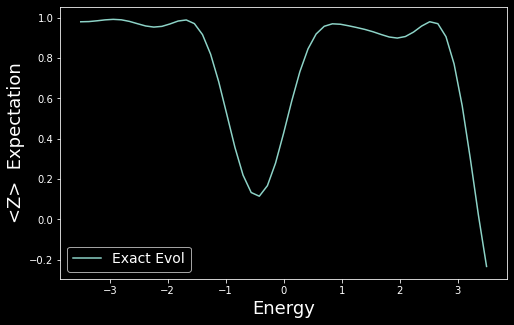

In [313]:
# test

fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(energies, np.real(prob0_exact), label='Exact Evol')
ax.set_xlabel('Energy', fontsize=18)
ax.set_ylabel('<Z>  Expectation', fontsize=18)
ax.legend(loc=3, fontsize=14)
ax.plot()

### Opflow Trotter Evolution

In [314]:
if exp_str == 't_sweep':
    trot_steps = int(t_analyze/dt_analyze)
elif exp_str == 'c_sweep':
    trot_steps = int(t_set/dt_set)
elif exp_str == 'm_sweep':
    trot_steps = int(t_set/dt_set)
elif exp_str == 'y_sweep':
    trot_steps = int(t_set/dt_set)
    
sim_trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=trot_steps)).convert(evo_and_obsv)

In [315]:
diag_meas_op = PauliExpectation().convert(sim_trot_op.bind_parameters(param_bind))
simple_ham_exps = diag_meas_op.bind_parameters({ww: list(energies)})
prob0_amp_trot = simple_ham_exps.eval()

prob0_trot = []
for eidx,_ in enumerate(energies):
    #prob0_trot.append(prob0_amp_trot[eidx]*prob0_amp_trot[eidx].conjugate())
    prob0_trot.append(prob0_amp_trot[eidx]) # NOT squared

## Plot Simulations

[]

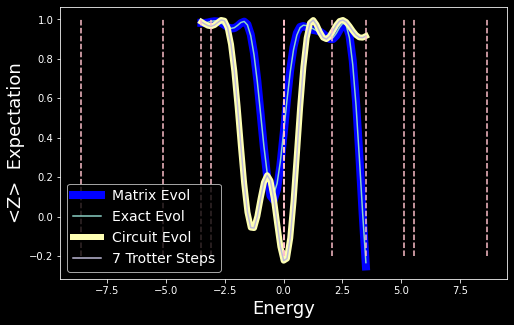

In [316]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(energies, np.real(prob0_matrix), label='Matrix Evol',linewidth=8,color='b')
ax.plot(energies, np.real(prob0_exact), label='Exact Evol')
ax.plot(energies, np.real(prob0_final), label='Circuit Evol',linewidth=6)
ax.plot(energies, np.real(prob0_trot), label=str(trot_steps)+' Trotter Steps')
for ev in D0:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D1:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D2:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D3:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
    
ax.set_xlabel('Energy', fontsize=18)
ax.set_ylabel('<Z>  Expectation', fontsize=18)
ax.legend(loc=3, fontsize=14)
ax.plot()

## Retrieve Results from Actual Job

In [317]:
if not dynamical_decoupling:
    P0_w = []
    for wi in range(len(w_range)):
        keys = list(Result[wi + idx0].keys())
        norm = sum([Result[wi + idx0][key] for key in keys]) 
        P0 = 0
        for key in keys:
            if key == '0000000': 
                P0 += Result[wi+idx0][key]/norm
        P0_w.append(P0)
else:
    num_dd_seqs = 3
    seq_length = len(res_circ_ddxy4)
    P0_w = np.zeros((num_dd_seqs, len(w_range)))
    for seq in range(num_dd_seqs):
        for wi in range(len(w_range)):
            keys = list(Result[wi + idx0 + seq*seq_length].keys())
            norm = sum([Result[wi + idx0 + seq*seq_length][key] for key in keys]) 
            P0 = 0
            for key in keys:
                if key[initial_layout[0]] == '0':
                    P0 += Result[wi+idx0+seq*seq_length][key]/norm
            P0_w[seq, wi] = P0

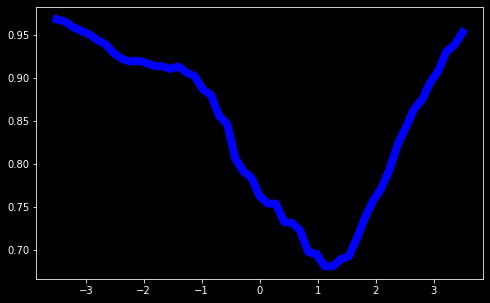

In [318]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
if not dynamical_decoupling:
    ax.plot(energies, P0_w, label='Matrix Evol',linewidth=8,color='b')
else:
    for seq in range(num_dd_seqs):
        ax.plot(energies, P0_w[seq], label='Matrix Evol',linewidth=8)

## Plot Results and Sims

This nominally should work without having the experimental data as well (i.e., for checks).

[]

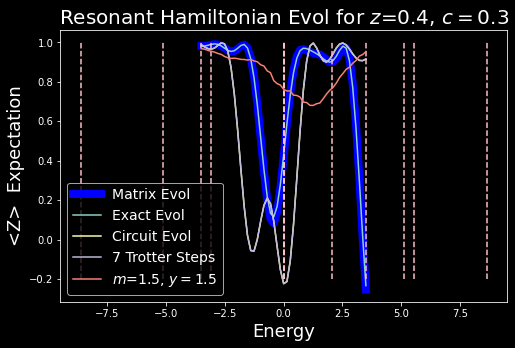

In [319]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(energies, np.real(prob0_matrix), label='Matrix Evol',linewidth=8,color='b')
ax.plot(energies, np.real(prob0_exact), label='Exact Evol')
ax.plot(energies, np.real(prob0_final), label='Circuit Evol')
ax.plot(energies, np.real(prob0_trot), label=str(trot_steps)+' Trotter Steps')
for ev in D0:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D1:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D2:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D3:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')

if exp_str == 't_sweep':
    try:
        ax.plot(w_range, P0_w, label='$t=$'+str(t_analyze)+', $dt=$'+str(dt_analyze))
    except:
        pass
    ax.set_title('Resonant Hamiltonian Evol for $c=$'+str(c_set), fontsize=20)
elif exp_str == 'c_sweep':
    try:
        ax.plot(w_range, P0_w, label='$c=$'+str(c_analyze))
    except:
        pass
    ax.set_title('Resonant Hamiltonian Evol for $t$='
                 +str(t_set)+', $dt=$'+str(dt_set), fontsize=20)
elif exp_str == 'm_sweep':
    try:
        ax.plot(w_range, P0_w, label='$m$='+str(m_analyze)+', $y=$'+str(y_set))
    except:
        pass
    ax.set_title('Resonant Hamiltonian Evol for $z$='
                 +str(z_set)+', $c=$'+str(c_set), fontsize=20)

ax.set_xlabel('Energy', fontsize=18)
ax.set_ylabel('<Z>  Expectation', fontsize=18)
ax.legend(loc=3, fontsize=14)
ax.plot()

## Save Results

In [320]:
save_data = False

if save_data:
    if exp_str == 't_sweep':
        np.save('../data/SE_1trot_N_2_c_'+str(c_set)+'_dt_'+str(dt_analyze)+'_t_'+str(t_analyze)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),P0_w)
        np.save('../data/w_N_2_c_'+str(c_set)+'_dt_'+str(dt_analyze)+'_t_'+str(t_analyze)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),w_range)
        np.save('../data/decoder_N_2_c_'+str(c_set)+'_dt_'+str(dt_analyze)+'_t_'+str(t_analyze)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),param_decoder)
    elif exp_str == 'c_sweep':
        np.save('../data/DD/SE_1trot_N_2_c_'+str(c_analyze)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),P0_w)
        np.save('../data/DD/w_N_2_c_'+str(c_analyze)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),w_range)
        np.save('../data/DD/decoder_N_2_c_'+str(c_analyze)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),param_decoder)
    elif exp_str == 'm_sweep':
        np.save('../data/final-sweeps/3site/SE_1trot_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_analyze)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),P0_w)
        np.save('../data/final-sweeps/3site/w_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_analyze)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),w_range)
        np.save('../data/final-sweeps/3site/decoder_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_analyze)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),param_decoder)
    elif exp_str == 'y_sweep':
        np.save('../data/DD/SE_1trot_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_analyze)+'_z_'+str(z_set),P0_w)
        np.save('../data/DD/w_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_analyze)+'_z_'+str(z_set),w_range)
        np.save('../data/DD/decoder_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_analyze)+'_z_'+str(z_set),param_decoder)

# Qiskit Version Table

In [321]:
import qiskit.tools.jupyter
%qiskit_version_table